In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import rawpy

In [3]:
import scipy.signal

In [4]:
def load_rgb(path, yrange=None, xrange=None):
    raw = rawpy.imread(path)
    rgb = raw.postprocess(demosaic_algorithm=rawpy.DemosaicAlgorithm.LINEAR,
                      output_bps=16, no_auto_bright=True, gamma=(2.5,3)).astype('float')

    if xrange and yrange:
        jupiter = rgb[yrange[0]:yrange[1],xrange[0]:xrange[1],:]
    else:
        jupiter = rgb
    return jupiter

def load_lum(path, yrange=None, xrange=None):
    jupiter = load_rgb(path, yrange, xrange)
    def lum(img):
        coeffs = [0.299, 0.587, 0.114 ]

        retval = np.zeros_like(img[:,:,0])
        for i, c_i in enumerate(coeffs):
            retval += c_i * img[:,:,i] # **2

        return retval # np.sqrt(retval)
    return lum(jupiter)

In [5]:
def find_align(f0, f1,max_dx=30, max_dy=30):
    # Make a little low-pass donut filter
    k = np.zeros((3,3))
    k += 1
    k[1,1] = 0
    k /= np.sum(k)

    deltas = np.zeros((max_dy, max_dx))

    f0p = scipy.signal.convolve2d(f0, k, mode='same')
    f1p = scipy.signal.convolve2d(f1, k, mode='same')
    
    for dx in range(max_dx):
        for dy in range(max_dy):

            d = f1p[:-max_dy,:-max_dx] - f0p[dy:(dy-max_dy),dx:(dx-max_dx)]
            deltas[dy,dx] = np.sqrt(np.sum(d*d))

    return np.unravel_index(np.argmin(deltas), deltas.shape)

In [12]:
def load_stack(paths, yrange, xrange):
    frames = [ load_lum(paths[0], yrange, xrange)]
    
    for p in paths[1:]:
        f_orig = load_lum(p, yrange, xrange)
        o = find_align(frames[0], f_orig)
        yrp = (yrange[0]-o[0], yrange[1]-o[0])
        xrp = (xrange[0]-o[1], xrange[1]-o[1])
        print "Loading %s at -%s" % (p, o)
        f_aligned = load_lum(p, yrp, xrp)
        frames.append(f_aligned)
    return frames

Loading IMG_0253.CR2 at -(4, 9)
Loading IMG_0254.CR2 at -(0, 9)
Loading IMG_0255.CR2 at -(0, 5)
Loading IMG_0256.CR2 at -(13, 4)
Loading IMG_0257.CR2 at -(0, 0)
Loading IMG_0258.CR2 at -(0, 0)
Loading IMG_0259.CR2 at -(7, 0)


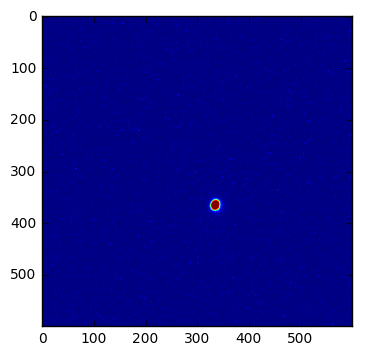

In [13]:
paths = [ "IMG_0%d.CR2" % i for i in [257] + range(253,260) ]
yrange = (800,1400)
xrange = (2400,3000)
frames = load_stack(paths, yrange, xrange)
imshow(frames[0])

In [14]:
j = np.zeros_like(frames[0])
divisor = 0
for f in frames:
    j += f
    divisor += 1.0
j /= divisor

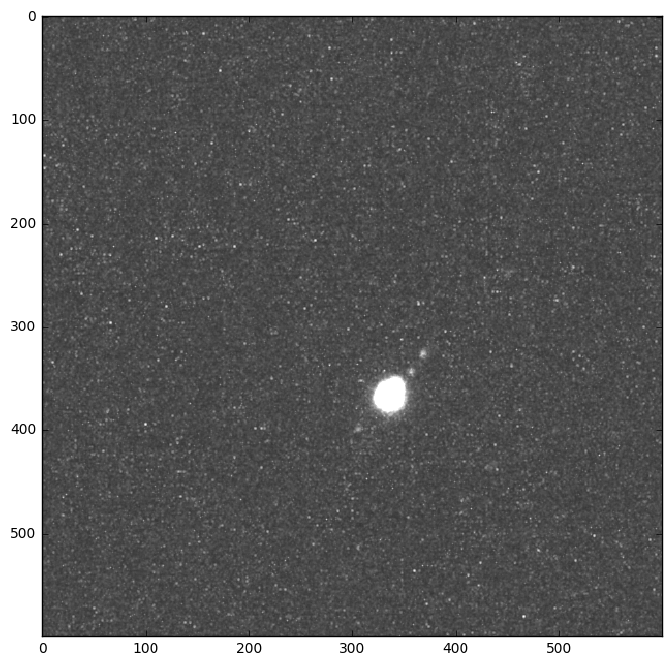

In [23]:
figure(figsize=(8,8))
imshow(j, cmap=cm.gray, vmin=-1000, vmax=4000, interpolation='none')